In [2]:
import os
import cv2
import tensorflow as tf
import torch
from torch import nn
from PIL import Image
import keras_ocr
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import splitfolders
import math
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [3]:
def plot_images(image_folder, n_rows, n_cols):
    # Get a list of all image files in the specified folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print("No image files found in the specified folder.")
        return

    
    # Calculate the total number of subplots needed
    total_subplots = n_rows * n_cols

    # Create a new figure with the specified number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    
    # Loop through each image file and plot it
    for i, image_file in enumerate(image_files[:total_subplots]):
        
        
        image_path = os.path.join(image_folder, image_file)

        # Read the image using cv2
        img = cv2.imread(image_path)
        img = cv2.resize(img, (128, 128))  # Resize to a fixed size
        # Convert BGR to RGB (OpenCV uses BGR by default)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image using matplotlib
        # Determine the subplot position
        row_position = i // n_cols
        col_position = i % n_cols

        # Plot the image in the corresponding subplot
        axes[row_position, col_position].imshow(img_rgb)
        axes[row_position, col_position].set_title(image_file)
        axes[row_position, col_position].axis('off')  # Turn off axis labels
        
    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()


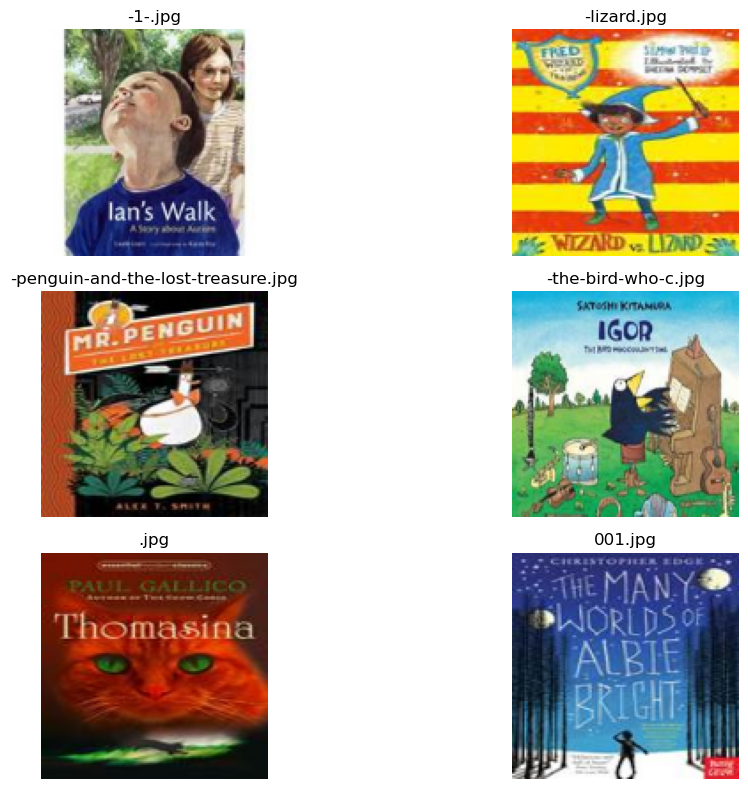

In [4]:
plot_images('archive/BookCovers/',3,2)

## The covers all have quite large text that will impact model performance when generating new images. 

The next steps will aim to remove the text. This is not expected to generate perfect results, however should prove to later better the results produced by the generator and discrimator.

In [ ]:
# https://towardsdatascience.com/remove-text-from-images-using-cv2-and-keras-ocr-24e7612ae4f4

def midpoint(x1, y1, x2, y2):
    # Calculate the midpoint between two points
    x_mid = int((x1 + x2) / 2)
    y_mid = int((y1 + y2) / 2)
    return (x_mid, y_mid)

# Initialize the OCR pipeline
pipeline = keras_ocr.pipeline.Pipeline()

def inpaint_text(img_path, pipeline):
    # Read the image
    img = keras_ocr.tools.read(img_path)

    # Generate word and box tuples using the OCR pipeline
    prediction_groups = pipeline.recognize([img])

    # Create an empty mask with the same dimensions as the image
    mask = np.zeros(img.shape[:2], dtype="uint8")

    # Iterate through each word box in the OCR predictions
    for box in prediction_groups[0]:
        # Extract coordinates of the four corners of the box
        x0, y0 = box[1][0]
        x1, y1 = box[1][1]
        x2, y2 = box[1][2]
        x3, y3 = box[1][3]

        # Calculate midpoints of opposite sides of the box
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mid1 = midpoint(x0, y0, x3, y3)

        # Calculate thickness based on the distance between two points
        thickness = int(math.sqrt((x2 - x1)**2 + (y2 - y1)**2))

        # Draw a line on the mask connecting the midpoints
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mid1), 255, thickness)

    # Use the inpaint function to remove the text based on the generated mask
    img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)

    return img

In [ ]:
no_text = inpaint_text('archive/BookCovers/1moledighole.jpg',pipeline)

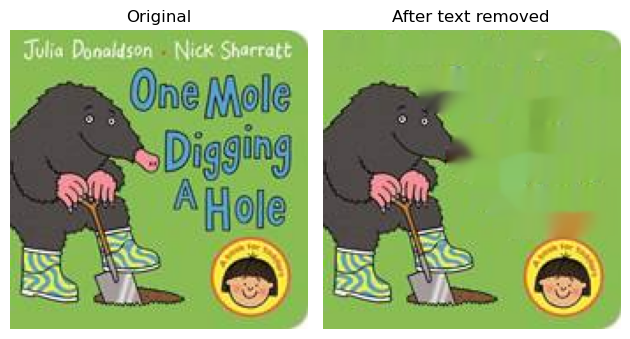

In [7]:
# Read the image using cv2
img = cv2.imread('archive/BookCovers/1moledighole.jpg')
# Convert BGR to RGB (OpenCV uses BGR by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img_rgb)
axs[0].set_title('Original')
axs[0].axis('off')  # Turn off axis labels

axs[1].imshow(no_text)
axs[1].set_title('After text removed')
axs[1].axis('off')  # Turn off axis labels
        
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
image_files = [f for f in os.listdir('archive/BookCovers/') if f.endswith(('.png', '.jpg', '.jpeg'))]

for _file in image_files:
        
    img = inpaint_text('archive/BookCovers/' + _file, pipeline)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite('no_text/'+ _file,img_rgb)

Now that text has been removed, the models can be trained,

In [31]:
splitfolders.ratio('no_text/', output="data", seed=1337, ratio=(.8, 0.2,0.0)) 

Copying files: 6231 files [00:36, 170.28 files/s]


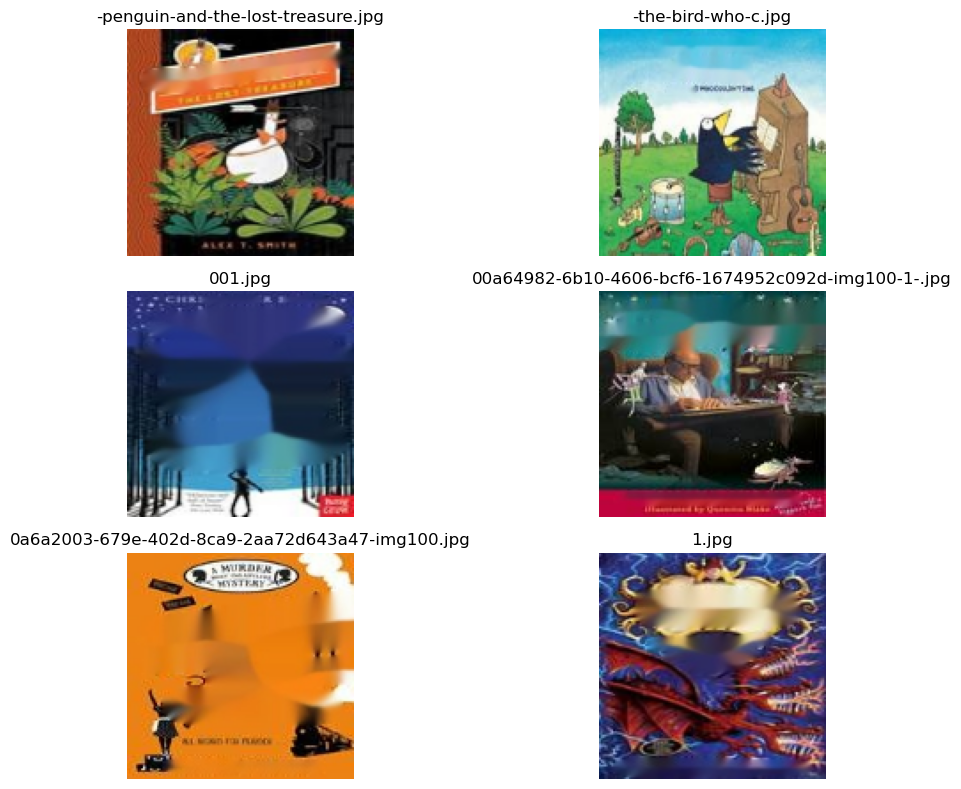

In [6]:
train_image_folder_path = 'data/train/images/'
val_image_folder_path = 'data/val/images'
plot_images(train_image_folder_path,3,2)

## 